# <center>Data Mining Project 2 Spring semester 2019-2020</center>
## <center>Παναγιώτης Ευαγγελίου &emsp; 1115201500039</center>
## <center>Γεώργιος Μαραγκοζάκης &emsp; 1115201500089</center>

___

### Do all the necessary imports for this notebook

In [1]:
# data processing
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# visualization
from wordcloud import WordCloud
from IPython.display import Image
from IPython.display import display

# classification
from sklearn.model_selection import KFold
from sklearn import svm, preprocessing
from sklearn.metrics import classification_report, accuracy_score

# vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# for data exploration
import os
import numpy as np

## __Dataset Preprocessing__

- ### *Make tsv files from all the txt files*

In [2]:
myCategoriesFolder = ['business','entertainment','politics', 'sport', 'tech']
dataPathDir = './fulltext/data/'

myDataSetDf = pd.DataFrame(columns=['ID', 'TITLE',  'CONTENT',  'CATEGORY'])
id_count = 0

for category in myCategoriesFolder:
    specificPath = dataPathDir + category + '/'

    # find the column's names of each csv
    for fileName in os.listdir(specificPath):
        # we need to check only .txt files
        if fileName.endswith(".txt"):
            
            thisTxt = open(os.path.join(specificPath, fileName),"r")
            thisTxtTitle = thisTxt.readline()

            # get rid of '\n' on the end of title line
            thisTxtTitle = thisTxtTitle.replace('\n', '')

            thisTxtContent = thisTxt.readlines()

            # get rid of empty lines '\n'
            thisTxtContent = list(filter(lambda a: a != '\n', thisTxtContent))

            # get rid of '\n' on the end of each line 
            thisTxtContent = [period.replace('\n', '') for period in thisTxtContent]

            # convert list of lines into a single string line
            thisTxtContent = ' '.join(thisTxtContent)

            myDataSetDf = myDataSetDf.append({'ID': id_count, 'TITLE': thisTxtTitle, 'CONTENT': thisTxtContent, 'CATEGORY': category.upper()}, ignore_index=True)
            thisTxt.close()

            id_count += 1

display(myDataSetDf)

,ID,TITLE,CONTENT,CATEGORY
0,0,Giant waves damage S Asia economy,"Governments, aid agencies, insurers and travel...",BUSINESS
1,1,EMI shares hit by profit warning,Shares in music giant EMI have sunk by more th...,BUSINESS
2,2,Barclays shares up on merger talk,Shares in UK banking group Barclays have risen...,BUSINESS
3,3,Trial begins of Spain's top banker,"The trial of Emilio Botin, the chairman of Spa...",BUSINESS
4,4,MG Rover China tie-up 'delayed',MG Rover's proposed tie-up with China's top ca...,BUSINESS
...,...,...,...,...
2219,2219,DVD copy protection strengthened,DVDs will be harder to copy thanks to new anti...,TECH
2220,2220,Slimmer PlayStation triple sales,Sony PlayStation 2's slimmer shape has proved ...,TECH
2221,2221,Format wars could 'confuse users',"Technology firms Sony, Philips, Matsushita and...",TECH
2222,2222,Mobile TV tipped as one to watch,"Scandinavians and Koreans, two of the most adv...",TECH


## __Make wordcloud for each category__

In [3]:
def makeWordCloud(myText, saveLocationPath, myMaxWords=100, myMask=None, myStopWords=None):
    '''Default function for generating wordcloud'''

    wc = WordCloud(background_color="white", mask=myMask, max_words=myMaxWords,
                   stopwords=myStopWords, contour_width=3, contour_color='steelblue',
                   width=600, height=600)

    # generate word cloud
    wc.generate(myText)

    # store to file

    wc.to_file(saveLocationPath)

    return saveLocationPath

In [4]:
def columnToText(myDfColumn):
    wholeColumnText = ''

    for text in myDfColumn:
        wholeColumnText = wholeColumnText + ' ' + text

    return wholeColumnText

- ### *Business Wordcloud*

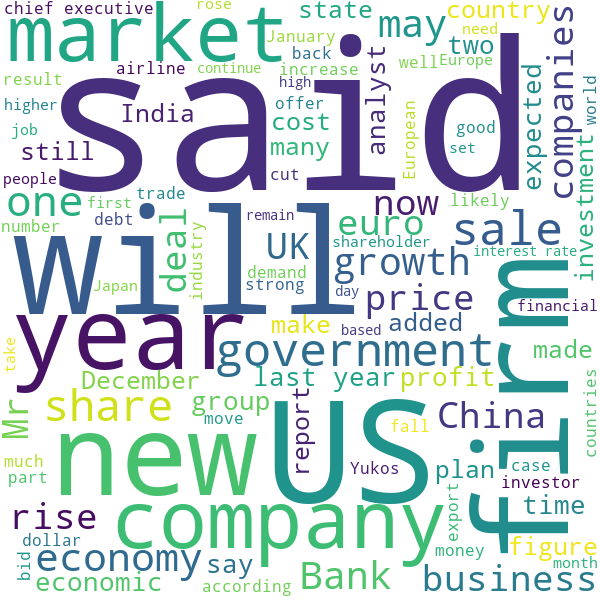

In [5]:
makeWordCloud(saveLocationPath="businessWordCloud.png", myText=columnToText(myDataSetDf[myDataSetDf['CATEGORY'] == "BUSINESS"]['CONTENT']))

Image('businessWordCloud.png')

- ### *Entertainment Wordcloud*

In [6]:

# to fill


- ### *Politics Wordcloud*

In [7]:

# to fill


- ### *Sport Wordcloud*

In [8]:

# to fill


- ### *Tech Wordcloud*

In [9]:

# to fill


## __Classification__

  - #### Classification using SVM classifier

In [10]:
def SvmClassification(trainX, trainY, testX, testY, labelEncoder):
    """
    Classify the text using the SVM classifier of scikit-learn    
    """
    
    clf = svm.SVC(kernel='linear', C=1, probability=True)

    # fit train set
    clf.fit(trainX, trainY)
    
    # use 10-fold Cross Validation

    print('----Report for 10-fold Cross Validation----')

    # skf = StratifiedKFold(n_splits=10)
    # precisions = cross_val_score(clf, trainX, trainY, cv=skf, scoring='precision_weighted')

    precisions = cross_val_score(clf, trainX, trainY, cv=10, scoring='precision_weighted')
    print ('Precision ', np.mean(precisions))

    recalls = cross_val_score(clf, trainX, trainY, cv=10, scoring='recall_weighted')
    print ('Recalls ', np.mean(recalls))

    f1s = cross_val_score(clf, trainX, trainY, cv=10, scoring='f1_weighted')
    print ('F-Measure ', np.mean(f1s))

    scores = cross_val_score(clf, trainX, trainY, cv=10)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    # Predict test set
    predY = clf.predict(testX)

    # Classification_report
    print('----Report for predictions on test dataset----')
    print(classification_report(testY, predY, target_names=list(labelEncoder.classes_)))

    print('----ROC plot for predictions on test dataset----')
    return accuracy_score(testY, predY)

  - #### Classification using Random Forests classifier

In [11]:

# to fill


  - #### Classification using Naive Bayes classifier

In [12]:

# to fill


  - #### Classification using K-Nearest Neighbor classifier

In [13]:

# to fill


- ### *Split DataSet into TrainData and TestData*

In [14]:
trainDataSet, testDataSet = train_test_split(myDataSetDf, test_size=0.2, stratify=myDataSetDf['CATEGORY'])

# reset index
trainDataSet.reset_index(drop=True, inplace=True)
testDataSet.reset_index(drop=True, inplace=True)

# save to tsv files
trainDataSet.to_csv('train_set.tsv', sep = '\t')

# save test_set categories
testDataSetCategories = testDataSet[['CATEGORY']].copy()

testDataSetCategories.to_csv('test_set_categories.tsv', sep = '\t')

testDataSet = testDataSet.drop('CATEGORY', axis=1)
testDataSet.to_csv('test_set.tsv', sep = '\t')

In [15]:
trainDataSet

,ID,TITLE,CONTENT,CATEGORY
0,833,Eastwood's Baby scoops top Oscars,Clint Eastwood's Million Dollar Baby beat Mart...,ENTERTAINMENT
1,659,Doves soar to UK album summit,Manchester rock band Doves have entered the UK...,ENTERTAINMENT
2,1139,Wales 'must learn health lessons',The new health minister for Wales says there a...,POLITICS
3,1644,Johnson too strong for GB runners,Britain's Kathy Butler and Hayley Yelling were...,SPORT
4,921,Howard attacks cost of asylum,Michael Howard has launched an attack on the c...,POLITICS
...,...,...,...,...
1774,938,Labour chooses Manchester,The Labour Party will hold its 2006 autumn con...,POLITICS
1775,17,UK economy facing 'major risks',The UK manufacturing sector will continue to f...,BUSINESS
1776,168,BMW drives record sales in Asia,BMW has forecast sales growth of at least 10% ...,BUSINESS
1777,2197,'Blog' picked as word of the year,"The term ""blog"" has been chosen as the top wor...",TECH


In [16]:
testDataSet

,ID,TITLE,CONTENT
0,806,Hanks greeted at wintry premiere,Hollywood star Tom Hanks was in London's Leice...
1,2086,Microsoft makes anti-piracy move,Microsoft says it is clamping down on people r...
2,1536,Munster Cup tie switched to Spain,Munster's Heineken Cup quarter-final tie again...
3,547,Oscar nominees gear up for lunch,"Leonardo DiCaprio, Jamie Foxx and Hilary Swank..."
4,197,Swiss cement firm in buying spree,Swiss cement firm Holcim has bid $800m (£429m)...
...,...,...,...
440,1424,Kirwan demands Italy consistency,Italy coach John Kirwan has challenged his sid...
441,1209,Labour faces 'cold calls' inquiry,Labour is to be investigated by a watchdog ove...
442,1716,Desailly backs Blues revenge trip,Marcel Desailly insists there is no chance of ...
443,458,Deutsche Telekom sees mobile gain,German telecoms firm Deutsche Telekom saw stro...


Prepare train and test data that we will need below

In [17]:
# build label encoder for categories
le = preprocessing.LabelEncoder()
le.fit(trainDataSet["CATEGORY"])

# transform categories into numbers
trainY = le.transform(trainDataSet["CATEGORY"])
testY = le.transform(testDataSetCategories["CATEGORY"])

accuracyDict = dict()

## __Vectorization__

Let's do classification using 2 different ways of vectorization

  - #### Bag-of-words vectorization

In [18]:
bowVectorizer = CountVectorizer(max_features=1000)

trainX = bowVectorizer.fit_transform(trainDataSet['CONTENT'])
testX = bowVectorizer.transform(testDataSet['CONTENT'])

print('-------------SVM Classification with BOW Vectorization-------------')
accuracyDict["BOW-SVM"] = SvmClassification(trainX, trainY, testX, testY, le)
#accuracyDict["BOW-SVM"] = SvmClassification(trainX, trainY, trainX, trainY, le)

-------------SVM Classification with BOW Vectorization-------------
----Report for 10-fold Cross Validation----
Precision  0.9454452091094316
Recalls  0.9437821367358599
F-Measure  0.9437764554304463
Accuracy: 0.94 (+/- 0.03)
----Report for predictions on test dataset----
               precision    recall  f1-score   support

     BUSINESS       0.94      0.94      0.94       102
ENTERTAINMENT       0.95      0.99      0.97        77
     POLITICS       0.95      0.90      0.93        84
        SPORT       1.00      1.00      1.00       102
         TECH       0.96      0.97      0.97        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445

----ROC plot for predictions on test dataset----


  - #### Tf-idf vectorization

In [ ]:
tfIdfVectorizer = TfidfVectorizer(max_features=3000)

trainX = tfIdfVectorizer.fit_transform(trainDataSet['CONTENT'])
testX = tfIdfVectorizer.transform(testDataSet['CONTENT'])

print('-------------SVM Classification with TfIdf Vectorization-------------')
accuracyDict["TfIdf-SVM"] = SvmClassification(trainX, trainY, testX, testY, le)

-------------SVM Classification with TfIdf Vectorization-------------
----Report for 10-fold Cross Validation----
Precision  0.975112029979601
Recalls  0.9741446073763728
F-Measure  0.9742151052905124
